# House prices and residential investments

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [151]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model description

We use a static modelling of the housing market from Sørensen and Whitta-Jacobsen 2010, Introducing Advanced Macroecnomics.

**Supply**

 Consider a representative construction firm which produces and sells on a perfect competition market. The firm produces housing stock according to the production function: $I=A\cdot X^\beta$, where $X=aL+bQ$ is a composite input consisting of $a$ units of labour and $b$ units of materials. The condition $0<\beta<1$ ensures diminishing returns to scale which is plausible, as the amount of land is scarce both in the short and long run. The price of one composite input is denoted construction costs and equals: $P=aW+bp^Q$. Thus, the representative firm faces the maximization problem:
\begin{equation}
\underset{I}{\arg\max}\ \Pi(I)=\underset{I}{\arg\max}\ P^HI-PX=\underset{I}{\arg\max}\ P^HI-P\left(\frac{I}{A}\right)^\frac{1}{\beta}
\end{equation}
Where $P^H$ is house prices. The housing stock evolves according to a simple identity: $H_{+1}=H(1-\delta)+I^*$. In absence of economic and population growth, it is plausible to assume $I^*=\delta H\iff H=\frac{I^*}{\delta}$ in the long run.

**Demand**

A representative consumer with Cobb-Douglas utility maximizes
\begin{equation*}
\underset{H,C}{\arg\max}\ H^\eta C^{1-\eta}, \; \text{st.} \; (1-m)Y= C+uP^HH
\end{equation*}
where $H$ is consumption of housing service, $C$ is consumption of other nondurable goods than housing and $\eta$ denotes relative preference for housing. Utility is maximized subject to a budget constraint. $(1-m)Y$ is disposable income. $u$ is a user cost measure to be specified below. $H$ is the size of the housing stock. The price of nondurable goods is normalized to 1. The user costs are given as
\begin{equation*}
u=(1-d)i-\pi^e+\delta+\tau)P^HH
\end{equation*}
The consumer pays interest $i$ on mortgage debt, however the government offers mortgage relief to such an extend that a fracition $d$ is deducted from interest expenses. Hence the after tax interest rate is $(1-d)i$, and the after tax real interest rate is $(1-d)i-\pi^e$. $\delta$ is the depreciation costs of housing, which inflicts a cost to the consumer. Finally $\tau$ is the effective tax rate on real estate.

## Analytical solution

We will derive the analytical solution manually first

**Supply**

The firm produces at the intersection between marginal revenue and marginal costs: $\frac{\partial\left( P^HI\right)}{\partial I}=\frac{\partial\left( PX\right)}{\partial I}\iff \frac{\partial\Pi}{\partial I}=0$, which is the first order condition. Solving for $I$ yields the optimal production level:
\begin{equation*}
    \frac{\partial\Pi}{\partial I}=0\implies P^H-\frac{P}{A\beta}\left(\frac{I}{A}\right)^{\frac{1-\beta}{\beta}}=0\iff
\end{equation*}
 
\begin{equation}
    I^*=k\left(\frac{P^H}{P}\right)^\frac{\beta}{1-\beta},\quad k=\beta^\frac{\beta}{1-\beta}A^\frac{1}{1-\beta}
\end{equation}
The housing stock evolves according to a simple identity: $H_{+1}=H(1-\delta)+I^*$. In absence of economic and population growth, it is plausible to assume $I^*=\delta H$ in the long run. This would imply, a long-run supply curve for housing is given by:
\begin{equation}
    H^s=\frac{k}{\delta}\left(\frac{P^H}{P}\right)^\frac{\beta}{1-\beta}
\end{equation}

**Demand**

Solve for $C$ in the budget constraint
\begin{equation}
    C=(1-m)Y-uP^HH
\end{equation}
Substitute in the utility function
\begin{equation}
   u(H) = H^\eta\left((1-m)Y-uP^HH\right)^{1-\eta}
\end{equation}
FOC
\begin{equation}
   \frac{du}{dH} = 0\iff \eta H^{\eta-1}\left((1-m)Y-uP^HH\right)^{1-\eta}-H^\eta (1-\eta)\left((1-m)Y-uP^HH\right)^{-\eta}uP^H=0\iff
\end{equation}
 
\begin{equation}
   \eta H^{\eta-1}\left((1-m)Y-uP^HH\right)^{1-\eta}=H^\eta (1-\eta)\left((1-m)Y-uP^HH\right)^{-\eta}uP^H\iff
\end{equation}
 
\begin{equation}
   \eta H^{-1}\left((1-m)Y-uP^HH\right)=(1-\eta)uP^H\iff
\end{equation}
 
\begin{equation}
   \frac{\eta(1-m)Y}{H}-\eta u P^H=(1-\eta)uP^H
\end{equation}
 
\begin{equation}
   H^d=\frac{\eta(1-m)Y}{uP^H} = \frac{\eta(1-m)Y}{((1-d)i-\pi^e+\delta+\tau)P^H}
\end{equation}

**Equilibrium**

In the long run, the partial equilibrium must satisfy the market clearing condition: $H^s=H^d$. Solve for $P^H$ and $H$ to find the long-run market clearing price and quantity:
\begin{equation}
    \left(P^H\right)^*=P^\beta\left(\frac{\delta\eta}{k}\cdot\frac{(1-m)Y}{(1-d)i-\pi^e+\delta+\tau}\right)^{1-\beta}
\end{equation}

\begin{equation}
    H^*=\left(\frac{k}{\delta}\right)^{1-\beta}\left(\frac{\eta(1-m)Y}{((1-d)i-\pi^e+\delta+\tau)P}\right)^\beta
\end{equation}


## Analytical solution using sympy

This section derives the analytical solution using sympy. Below sybols are defined

In [ ]:
PH = sm.symbols('P^H')
I = sm.symbols('I')
P = sm.symbols('P')
A = sm.symbols('A')
beta = sm.symbols('beta')
H = sm.symbols('H')
delta = sm.symbols('delta')
C = sm.symbols('C')
eta = sm.symbols('eta')
m = sm.symbols('m')
Y = sm.symbols('Y')
d = sm.symbols('d')
i = sm.symbols('i')
pi = sm.symbols('pi')
tau = sm.symbols('tau')

### Supply

In [ ]:
#Defining profit function
profit = PH*I-P*(I/A)**(1/beta)
profit

In [ ]:
# Firts order condition. Note this is an unconstrained optimization problem of 1 variable.
foc_s = sm.diff(profit, I)
foc_s

In [ ]:
# Solving for optimal investment level
sol_s = sm.solve(sm.Eq(foc_s,0), I)
sol_s[0]

In [ ]:
# This implies the following steady state value of housing stock as argued above
H_s = sol_s[0]/delta
H_s

In [ ]:
# Solving for PH in the equation above to find an inverse supply function. We use this to find the equilibrium housing stock level later.
PH_s = sm.solve(sm.Eq(H_s,H),PH)
PH_s[0]

### Demand

In [ ]:
# Defining utility function and budget constraint. Note this is a constrained optimization problem of 2 variables.
utility = H**eta*C**(1-eta)
utility
budget_constraint = sm.Eq(C+((1-d)*i-pi+delta+tau)*PH*H,(1-m)*Y)
budget_constraint

In [ ]:
# isolate C on LHS in the budget constraint
C_from_con = sm.solve(budget_constraint, C)
C_from_con[0]

In [ ]:
# Substituting C into the utility function
utility_subs = utility.subs(C, C_from_con[0])
utility_subs

In [ ]:
#First order condition with respect to H
foc_d = sm.diff(utility_subs, H)
foc_d

In [ ]:
# Solving to find a demand function for housing service
sol_d = sm.solve(sm.Eq(foc_d,0), H)
H_d = sol_d[0]
H_d

In [ ]:
#Isolating PH in the demand function to find an inverse demand function. We use this to find the equilibrium housing stock level below
PH_d = sm.solve(sm.Eq(H_d,H),PH)
PH_d[0]

### Equilibrium

In [ ]:
#We equalize the inverse supply and demand function and solve for H to find the steady state equilibrium of housing stock as function of parameters
equilibrium_H = sm.Eq(PH_s[0],PH_d[0])
sol_equilibrium_H = sm.solve(equilibrium_H,H)
sol_equilibrium_H[0]
# This is equal to the solution found manually - only more messy

In [ ]:
#We equalize the supply and demand functions and solve for PH to find the steady state equilibrium house prices level as function of parameters
equilibrium_PH = sm.Eq(H_s,H_d)
sol_equilibrium_PH = sm.solve(equilibrium_PH,PH)
sol_equilibrium_PH[0]
# This is equal to the solution found manually - only more messy

## Numerical solution

### Supply side

In [ ]:
def profit(I,PH,P,A,beta):
    return PH*I - P*(I/A)**(1/beta)

PH = 10
P = 1
A = 1
beta = 0.1

result = optimize.minimize_scalar(lambda x: -profit(x,PH,P,A,beta), method='golden')
I = result.x
pi = profit(I,PH,P,A,beta)
print(I)
print(pi)


In [152]:
def profit(I, PH, P, A, beta):
    return PH*I - P*(I/A)**(1/beta)

P = 1
A = 1
delta = 0.01

# Define range of beta and PH values
beta_values = np.linspace(0.8, 0.9, num=6)
PH_values = np.linspace(1, 4, num=100)

# Create an empty array to store the results
I_opt_s = np.zeros((len(beta_values), len(PH_values)))
H_opt_s = np.zeros((len(beta_values), len(PH_values)))

# Loop over beta and PH values and solve the profit function
for i, beta in enumerate(beta_values):
    for j, PH in enumerate(PH_values):
        result = optimize.minimize_scalar(lambda x: -profit(x,PH,P,A,beta), method='golden')
        I = result.x
        pi = profit(I,PH,P,A,beta)
        I_opt_s[i,j] = I  # Store optimal investment level
        H_opt_s[i,j] = I/delta  # Store steady state housing stock level

#### Optimal investment level

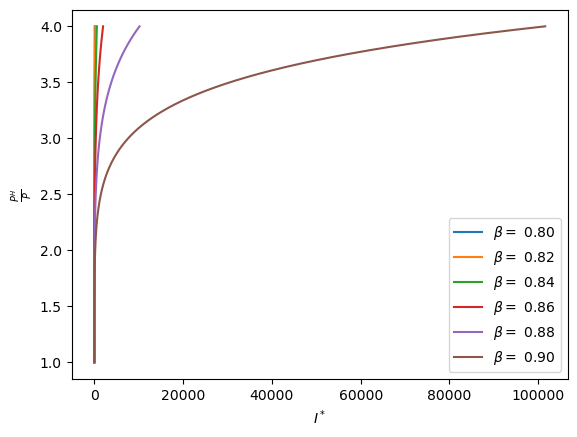

In [153]:
fig = plt.figure()
for v, beta in enumerate(beta_values):
    plt.plot(I_opt_s[v,:],PH_values, label=r'$\beta=$ {:.2f}'.format(beta))
plt.xlabel(r'$I^*$')
plt.ylabel(r'$\frac{P^H}{P}$')
plt.legend()

#### steady state housing stock level

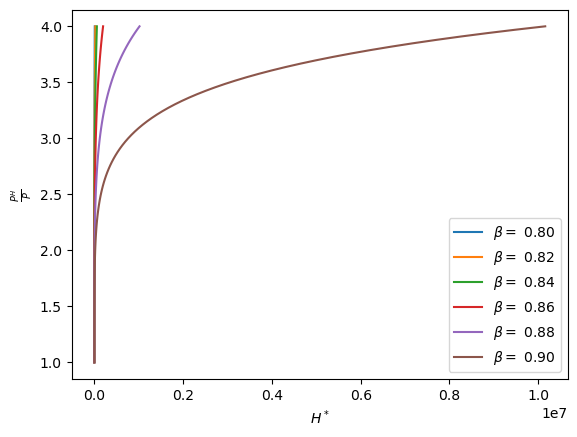

In [154]:
fig = plt.figure()
for v, beta in enumerate(beta_values):
    plt.plot(H_opt_s[v,:],PH_values, label=r'$\beta=$ {:.2f}'.format(beta))
plt.xlabel(r'$H^*$')
plt.ylabel(r'$\frac{P^H}{P}$')
plt.legend()

### Demand

In [ ]:
del i,j

def u_func(H,C,eta):
    return H**eta * C**(1-eta)

Y=10000
m=0.5
d=0.3
i=0.05
pie=0.02
delta=0.02
tau=0.02
u=(1-d)*i-pie+delta+tau
Y_disp = (1-m)*Y


# Define range of beta and PH values
eta_values = np.linspace(0.1, 0.9, num=5)
PH_values = np.linspace(0.5, 10, num=100)

# Create an empty array to store the results
H_opt_d = np.zeros((len(eta_values), len(PH_values)))
C_opt_d = np.zeros((len(eta_values), len(PH_values)))

# Loop over beta and PH values and solve the profit function
for i, eta in enumerate(eta_values):
    for j, PH in enumerate(PH_values):
        # a. objective function (to minimize)
        def value_of_choice(x,eta,PH,u,Y_disp):
        # note: x is a array, but u_func takes scalars.
            return -u_func(x[0],x[1],eta)

        # b. constraints (violated if negative) and bounds. x is an array.
        constraints = ({'type': 'ineq', 'fun': lambda x:  Y_disp-PH*u*x[0]-x[1]})
        bounds = ((0,Y_disp/(PH*u)),(0,Y_disp))

        # c. call solver, use SLSQP
        initial_guess = [Y_disp/PH/2,Y_disp/2]

        sol_case2 = optimize.minimize(
            value_of_choice, initial_guess, args=(eta,PH,u,Y_disp),
            method='SLSQP', bounds=bounds, constraints=constraints)
        
        # d. unpack solution
        utility = u_func(H,C,eta)
        H_opt_d[i,j] = sol_case2.x[0]
        C_opt_d[i,j] = sol_case2.x[1]

In [ ]:
fig = plt.figure()
for v, eta in enumerate(eta_values):
    plt.plot(H_opt_d[v,:],PH_values, label=r'$\eta=$ {:.2f}'.format(eta))
plt.xlabel(r'$H^*$')
plt.ylabel(r'$\frac{P^H}{P}$')
plt.legend()

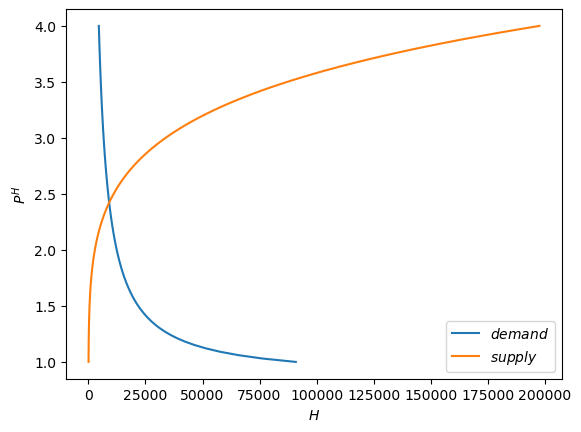

In [157]:
fig = plt.figure()
plt.plot(H_opt_d[2,:],PH_values, label=r'$demand$')
plt.plot(H_opt_s[3,:],PH_values, label=r'$supply$')
plt.xlabel(r'$H$')
plt.ylabel(r'$P^H$')
plt.legend()

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

#### Demand side

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 